<a href="https://colab.research.google.com/github/average81/KION/blob/scene_segmentation/Hakaton_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Комплексный анализ:

Видео: через анализ изменения контента

Аудио: через спектральный анализ

Субтитры: через семантическую схожесть

Объекты: через YOLO + ByteTrack

Гибкие настройки:

Весовые коэффициенты для каждого типа анализа

Настраиваемые пороги детекции

Поддержка русского языка для субтитров

Визуализация результатов:

График временной шкалы сценами

Подробный текстовый вывод

Оптимизации:

Эффективный трекинг объектов

Пакетная обработка данных

Четкое разделение этапов анализа

Как использовать:
Установите зависимости: pip install -r requirements.txt

Поместите видео и субтитры в одну папку

Укажите пути к файлам в конце скрипта

Запустите: python scene_analysis.py

In [1]:
!python -m spacy download ru_core_news_md
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python pytube moviepy pydub scenedetect[opencv] transformers
!pip install -q ultralytics
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q librosa pandas matplotlib seaborn
!pip install -q speechrecognition
!pip install opencv-python numpy ultralytics scenedetect librosa spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
import os
import cv2
import numpy as np
import re
import chardet
from dataclasses import dataclass
from typing import List, Tuple, Dict
from collections import defaultdict
from statistics import mean
import matplotlib.pyplot as plt
import librosa
import spacy
from scenedetect import VideoManager, SceneManager, ContentDetector
from ultralytics import YOLO
from moviepy.editor import VideoFileClip
import subprocess
import warnings
import matplotlib.pyplot as plt
from pytube import YouTube
import pandas as pd

t:  76%|███████▌  | 392/518 [01:00<00:16,  7.80it/s, now=None]

MoviePy - Writing audio in audio.wav



t:  76%|███████▌  | 392/518 [01:12<00:16,  7.80it/s, now=None]

MoviePy - Done.


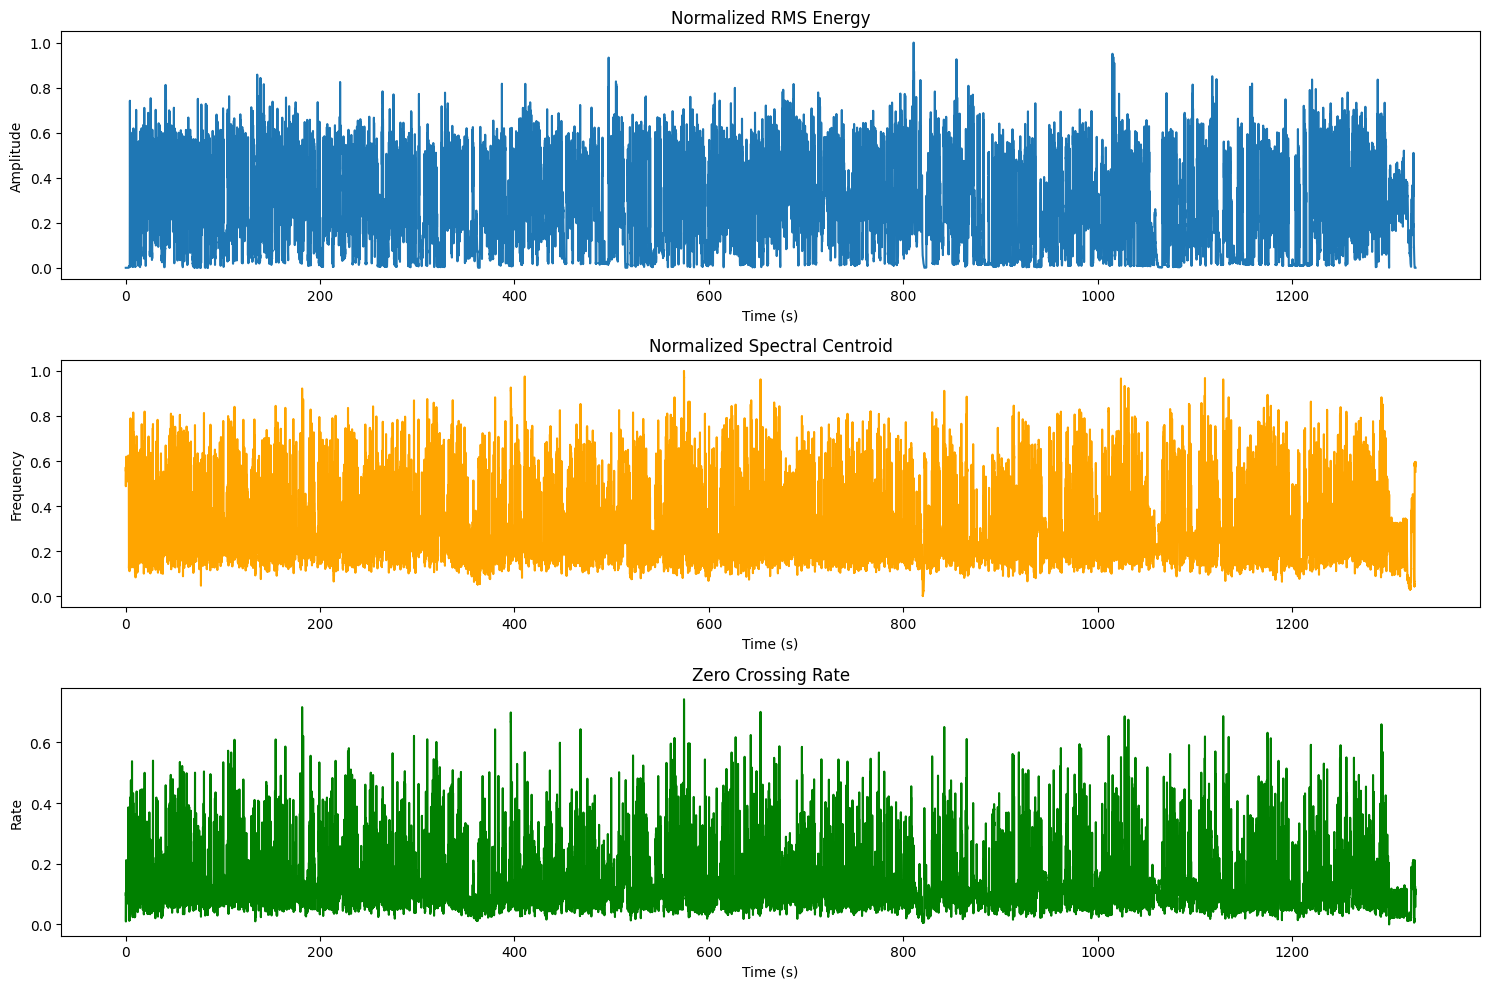

ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 23.976 FPS, resolution: 1908 x 1068
INFO:pyscenedetect:Detecting scenes...


Streaming output truncated to the last 5000 lines.
Speed: 3.4ms preprocess, 27.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 1 cup, 1 potted plant, 1 vase, 26.6ms
Speed: 3.8ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 1 cup, 1 potted plant, 1 vase, 26.6ms
Speed: 3.2ms preprocess, 26.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 1 cup, 1 potted plant, 1 vase, 27.7ms
Speed: 3.3ms preprocess, 27.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 1 cup, 1 potted plant, 1 vase, 27.1ms
Speed: 3.3ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 wine glass, 1 cup, 1 potted plant, 1 vase, 26.8ms
Speed: 3.7ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 38

In [ ]:
# Весовые коэффициенты и параметры
WEIGHTS = {
    'video': 0.5,               # вес для видео-анализа (ContentDetector)
    'audio': 0.3,               # вес для аудио-анализа
    'subtitles': 0.2,           # вес для анализа субтитров
    'min_duration': 10.0,        # минимальная длительность сцены (сек)
    'max_duration': 600.0,      # максимальная длительность сцены (сек)
    'rms_threshold': 0.3,       # порог для RMS энергии в аудио
    'centroid_threshold': 0.4,  # порог для спектрального центроида
    'sub_min_duration': 10.0,   # мин. длительность сцены по субтитрам
    'sub_time_gap': 3.0,        # макс. разрыв между репликами (сек)
    'sub_similarity': 0.55,     # порог семантической схожести текста
}

def download_youtube_video(url, output_path='./video.mp4'):
    yt = YouTube(url)
    stream = yt.streams.filter(file_extension='mp4', progressive=True).order_by('resolution').desc().first()
    stream.download(output_path=os.path.dirname(output_path), filename=os.path.basename(output_path))
    return output_path

def extract_audio_with_ffmpeg(video_path, audio_path='audio.wav'):
    cmd = ['ffmpeg', '-i', video_path, '-vn', '-acodec', 'pcm_s16le', audio_path]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    try:
        print(err.decode('utf-8'))
    except UnicodeDecodeError:
        print(err.decode('latin-1'))
    return audio_path

def extract_audio(video_path, audio_path='audio.wav'):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(audio_path, codec='pcm_s16le')
    return audio_path

def analyze_audio(audio_path, frame_length=2048, hop_length=512):
    y, sr = librosa.load(audio_path)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    spectral_centroid_normalized = (spectral_centroid - np.min(spectral_centroid)) / (np.max(spectral_centroid) - np.min(spectral_centroid))

    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length, n_fft=frame_length)

    return {
        'times': times,
        'rms': rms_normalized,
        'spectral_centroid': spectral_centroid_normalized,
        'zcr': zcr
    }

def plot_audio_features(audio_features):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    plt.plot(audio_features['times'], audio_features['rms'], label='RMS Energy')
    plt.title('Normalized RMS Energy')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(audio_features['times'], audio_features['spectral_centroid'], label='Spectral Centroid', color='orange')
    plt.title('Normalized Spectral Centroid')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 3)
    plt.plot(audio_features['times'], audio_features['zcr'], label='Zero Crossing Rate', color='green')
    plt.title('Zero Crossing Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Rate')

    plt.tight_layout()
    plt.show()

def detect_video_scenes(video_path, threshold=30.0):
    video = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector(threshold=threshold))
    video.set_downscale_factor()
    video.start()
    scene_manager.detect_scenes(frame_source=video)
    scene_list = scene_manager.get_scene_list()
    scenes = [(scene[0].get_seconds(), scene[1].get_seconds()) for scene in scene_list]
    return scenes

def detect_audio_scenes(audio_features):
    times = audio_features['times']
    rms = audio_features['rms']
    spectral_centroid = audio_features['spectral_centroid']
    scenes = []
    current_scene_start = 0.0

    for i in range(1, len(times)):
        rms_change = abs(rms[i] - rms[i-1])
        centroid_change = abs(spectral_centroid[i] - spectral_centroid[i-1])

        if rms_change > WEIGHTS['rms_threshold'] or centroid_change > WEIGHTS['centroid_threshold']:
            scene_duration = times[i] - current_scene_start
            if scene_duration >= WEIGHTS['min_duration']:
                scenes.append((current_scene_start, times[i]))
                current_scene_start = times[i]

    if current_scene_start < times[-1]:
        scenes.append((current_scene_start, times[-1]))
    return scenes

def extract_embedded_subtitles(video_path, output_srt_path='embedded_subtitles.srt'):
    """Извлекает встроенные субтитры из видеофайла с помощью ffmpeg"""
    try:
        cmd = [
            'ffmpeg',
            '-i', video_path,
            '-map', '0:s:0',
            '-c:s', 'srt',
            output_srt_path
        ]
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        if os.path.exists(output_srt_path) and os.path.getsize(output_srt_path) > 0:
            print(f"Извлечены встроенные субтитры в {output_srt_path}")
            return output_srt_path
    except subprocess.CalledProcessError as e:
        print(f"Не удалось извлечь встроенные субтитры: {e}")
    except Exception as e:
        print(f"Ошибка при извлечении субтитров: {e}")
    return None

def process_subtitles(srt_file_path):
    def read_srt_file(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except UnicodeDecodeError:
            with open(file_path, 'r', encoding='cp1251') as file:
                return file.read()

    def parse_srt(srt_text):
        subtitles = []
        blocks = re.split(r'\n\s*\n', srt_text.strip())

        for block in blocks:
            lines = block.strip().split('\n')
            if len(lines) < 3:
                continue

            try:
                index = int(lines[0])
                time_match = re.match(r'(\d{2}):(\d{2}):(\d{2}),(\d{3}) --> (\d{2}):(\d{2}):(\d{2}),(\d{3})', lines[1])
                if not time_match:
                    continue

                h1, m1, s1, ms1 = map(int, time_match.groups()[:4])
                h2, m2, s2, ms2 = map(int, time_match.groups()[4:8])
                start = h1 * 3600 + m1 * 60 + s1 + ms1 / 1000
                end = h2 * 3600 + m2 * 60 + s2 + ms2 / 1000
                text = '\n'.join(lines[2:])
                subtitles.append({'start': start, 'end': end, 'text': text})
            except Exception as e:
                continue

        return subtitles

    def group_into_scenes(subtitles):
        if not subtitles:
            return []

        scenes = []
        current_scene = [subtitles[0]]

        for prev, curr in zip(subtitles, subtitles[1:]):
            time_gap = curr['start'] - prev['end']
            if time_gap > WEIGHTS['sub_time_gap']:
                scenes.append(current_scene)
                current_scene = [curr]
            else:
                current_scene.append(curr)

        scenes.append(current_scene)
        scene_boundaries = []

        for scene in scenes:
            scene_start = scene[0]['start']
            scene_end = scene[-1]['end']
            if scene_end - scene_start >= WEIGHTS['sub_min_duration']:
                scene_boundaries.append((scene_start, scene_end))

        return scene_boundaries

    srt_text = read_srt_file(srt_file_path)
    subtitles = parse_srt(srt_text)
    return group_into_scenes(subtitles), subtitles

def merge_scenes(video_scenes, audio_scenes, subtitle_scenes=None):
    weighted_scenes = []

    for start, end in video_scenes:
        duration = end - start
        if duration >= WEIGHTS['min_duration']:
            weighted_scenes.append({
                'start': start,
                'end': end,
                'weight': WEIGHTS['video'],
                'type': 'video'
            })

    for start, end in audio_scenes:
        duration = end - start
        if duration >= WEIGHTS['min_duration']:
            weighted_scenes.append({
                'start': start,
                'end': end,
                'weight': WEIGHTS['audio'],
                'type': 'audio'
            })

    if subtitle_scenes:
        for start, end in subtitle_scenes:
            duration = end - start
            if duration >= WEIGHTS['min_duration']:
                weighted_scenes.append({
                    'start': start,
                    'end': end,
                    'weight': WEIGHTS['subtitles'],
                    'type': 'subtitles'
                })

    if not weighted_scenes:
        return []

    weighted_scenes.sort(key=lambda x: x['start'])
    merged_scenes = []
    current_scene = weighted_scenes[0].copy()

    for scene in weighted_scenes[1:]:
        scene_overlap = (scene['start'] <= current_scene['end'] + 2.0)
        duration_exceeded = (scene['end'] - current_scene['start']) > WEIGHTS['max_duration']

        if scene_overlap and not duration_exceeded:
            if scene['type'] == 'video' and current_scene['type'] != 'video':
                current_scene['end'] = scene['end']
                current_scene['weight'] += scene['weight']
                current_scene['type'] = 'mixed'
            elif scene['weight'] > current_scene['weight']:
                current_scene['end'] = scene['end']
                current_scene['weight'] += scene['weight']
                if scene['type'] != current_scene['type']:
                    current_scene['type'] = 'mixed'
            else:
                current_scene['end'] = max(current_scene['end'], scene['end'])
                current_scene['weight'] += scene['weight'] * 0.5
        else:
            if current_scene['end'] - current_scene['start'] >= WEIGHTS['min_duration']:
                merged_scenes.append((current_scene['start'], current_scene['end']))
            current_scene = scene.copy()

    if current_scene['end'] - current_scene['start'] >= WEIGHTS['min_duration']:
        merged_scenes.append((current_scene['start'], current_scene['end']))

    merged_scenes = [(start, end) for start, end in merged_scenes
                    if end - start >= WEIGHTS['min_duration']]
    return merged_scenes

def track_objects(video_path, output_path='output_tracked.mp4'):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    model = YOLO('yolov8l.pt')
    tracks_info = defaultdict(list)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, tracker="bytetrack.yaml")
        annotated_frame = results[0].plot()

        if results[0].boxes.id is not None:
            for box, track_id in zip(results[0].boxes, results[0].boxes.id):
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = box.conf[0].item()
                cls = box.cls[0].item()

                tracks_info[int(track_id)].append({
                    'frame': frame_count,
                    'time': frame_count / fps,
                    'bbox': [x1, y1, x2, y2],
                    'confidence': conf,
                    'class': cls
                })

        out.write(annotated_frame)
        frame_count += 1

    cap.release()
    out.release()
    return tracks_info, output_path

def final_scene_segmentation(merged_scenes, tracks_info, subtitles=None):
    final_scenes = []

    for scene_start, scene_end in merged_scenes:
        if scene_end - scene_start < WEIGHTS['min_duration']:
            continue

        scene_tracks = {}
        for track_id, track_data in tracks_info.items():
            objects_in_scene = [obj for obj in track_data if scene_start <= obj['time'] <= scene_end]
            if objects_in_scene:
                scene_tracks[track_id] = objects_in_scene

        scene_text = ""
        if subtitles:
            for sub in subtitles:
                if scene_start <= sub['start'] <= scene_end or scene_start <= sub['end'] <= scene_end:
                    scene_text += sub['text'] + " "

        final_scenes.append({
            'start': scene_start,
            'end': scene_end,
            'duration': scene_end - scene_start,
            'objects': scene_tracks,
            'text': scene_text.strip() if scene_text else None
        })

    return final_scenes

def visualize_scenes(final_scenes, video_path):
    cap = cv2.VideoCapture(video_path)
    duration = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    cap.release()

    plt.figure(figsize=(15, 5))
    for i, scene in enumerate(final_scenes):
        plt.axvspan(scene['start'], scene['end'], alpha=0.3, color=f'C{i}', label=f'Scene {i+1}')
    plt.title('Video Scene Segmentation')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Scenes')
    plt.legend()
    plt.show()

def save_scenes_as_videos(video_path, final_scenes, output_dir='./scenes'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_name = os.path.splitext(os.path.basename(video_path))[0]

    for i, scene in enumerate(final_scenes):
        output_path = os.path.join(output_dir, f"{video_name}_scene_{i+1}.mp4")
        clip = VideoFileClip(video_path).subclip(scene['start'], scene['end'])
        clip.write_videofile(output_path, codec='libx264', audio_codec='aac')
        print(f"Saved scene {i+1} to {output_path}")

def generate_report(final_scenes, output_path='report.csv'):
    def determine_scene_category(scene):
        object_classes = []
        for track_data in scene['objects'].values():
            for obj in track_data:
                object_classes.append(obj['class'])

        text = scene.get('text', '')
        text_length = len(text.split()) if text else 0

        if text_length > 30 and len(object_classes) < 3:
            return "Диалог"
        elif len(object_classes) > 5:
            return "Экшен"
        elif any(cls in [0, 1, 2, 3, 5, 7] for cls in object_classes):
            return "Персонажи"
        elif text_length > 10:
            return "Диалог/Наррация"
        else:
            return "Пейзаж/Обстановка"

    report_data = []
    for i, scene in enumerate(final_scenes):
        category = determine_scene_category(scene)
        scene_text = scene.get('text', '')
        if len(scene_text) > 200:
            scene_text = scene_text[:200] + "..."

        scene_info = {
            '№ сцены': i + 1,
            'Время начала': f"{scene['start']:.2f}",
            'Время конца': f"{scene['end']:.2f}",
            'Длительность (сек)': f"{scene['duration']:.2f}",
            'Текст': scene_text,
            'Категория': category,
            'Объектов': len(scene['objects'])
        }
        report_data.append(scene_info)

    df = pd.DataFrame(report_data)
    columns_order = ['№ сцены', 'Время начала', 'Время конца', 'Длительность (сек)',
                    'Категория', 'Объектов', 'Текст']
    df = df[columns_order]
    df.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"Отчет сохранен в {output_path}")
    return df

def main(video_path='mister-i-missis-smit-2005.mp4', srt_path=None):
    # 1. Извлечение аудио
    audio_path = extract_audio(video_path)
    audio_features = analyze_audio(audio_path)
    plot_audio_features(audio_features)

    # 2. Детекция сцен
    video_scenes = detect_video_scenes(video_path)
    audio_scenes = detect_audio_scenes(audio_features)

    # 3. Обработка субтитров
    subtitle_scenes, subtitles = None, None

    if srt_path and os.path.exists(srt_path):
        print(f"Используется внешний файл субтитров: {srt_path}")
        subtitle_scenes, subtitles = process_subtitles(srt_path)
    else:
        embedded_srt = extract_embedded_subtitles(video_path)
        if embedded_srt:
            print("Используются встроенные субтитры")
            subtitle_scenes, subtitles = process_subtitles(embedded_srt)
        else:
            print("Субтитры не найдены, анализ будет без учета субтитров")

    # 4. Объединение сцен
    merged_scenes = merge_scenes(video_scenes, audio_scenes, subtitle_scenes)

    # 5. Трекинг объектов
    tracks_info, _ = track_objects(video_path)

    # 6. Финальная сегментация
    final_scenes = final_scene_segmentation(merged_scenes, tracks_info, subtitles)

    # 7. Визуализация и сохранение результатов
    visualize_scenes(final_scenes, video_path)
    save_scenes_as_videos(video_path, final_scenes)
    report_df = generate_report(final_scenes)

    return final_scenes, report_df

if __name__ == "__main__":
    # Пример использования:
    # С внешними субтитрами
    # final_scenes, report = main(video_path='video.mp4', srt_path='subtitles.srt')

    # С автоматическим определением субтитров
    final_scenes, report = main(video_path='S1E01 - Pilot.mkv')